<a href="https://colab.research.google.com/github/KSU-MSBA/64060/blob/master/kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7: k-Nearest Neighbors (kNN)

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Modified from Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [ ]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pylab as plt



# Import Data

In [ ]:
carseats_df = pd.read_csv('https://raw.githubusercontent.com/KSU-MSBA/64060/master/carseats.csv',sep='\t')
carseats_df['Number']= carseats_df.index + 1
carseats_df.head(10)
carseats_df.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,Number
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000,200.500000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528,115.614301
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000,1.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000,100.750000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000,200.500000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000,300.250000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000,400.000000


## Partition the Data
Assume that we are interested in creating a training and validation set from this dataset. To simplify our illustration, we will restrict ourself to the following three variables: Sales, Education, Urban, and use only a small dataset for illustration

* First, we create a dataset with only the required columns. 
* Then, we use the *train_test_split* function from the *sklearn* library to create our training, validation and test sets 


In [ ]:
m_carseats_df = carseats_df[['Sales','Age','Urban','Number']]
m_carseats_df.head()

,Sales,Age,Urban,Number
0,9.50,42,Yes,1
1,11.22,65,Yes,2
2,10.06,59,Yes,3
3,7.40,55,Yes,4
4,4.15,38,Yes,5


In [ ]:
tempData, testData = train_test_split(carseats_df, test_size=0.2, random_state=26)
trainData, validData = train_test_split(tempData,test_size=0.25,random_state=15)
print(trainData.shape, validData.shape, testData.shape)
trainData[['Sales','Age']].describe()

(240, 12) (80, 12) (80, 12)


,Sales,Age
count,240.00000,240.000000
mean,7.66150,52.195833
std,2.92752,16.060528
min,0.16000,25.000000
25%,5.68000,39.000000
50%,7.62500,53.000000
75%,9.42000,64.000000
max,16.27000,80.000000


## Plotting
Let us now plot the data

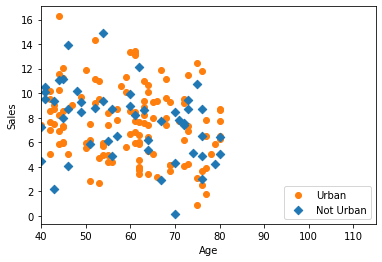

In [ ]:
fig, ax = plt.subplots()

subset = trainData.loc[trainData['Urban']=='Yes']
ax.scatter(subset.Age, subset.Sales, marker='o', label='Urban', color='C1')

subset = trainData.loc[trainData['Urban']=='No']
ax.scatter(subset.Age, subset.Sales, marker='D', label='Not Urban', color='C0')

plt.xlabel('Age')  # set x-axis label
plt.ylabel('Sales')  # set y-axis label
    
handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(40, 115)
ax.legend(handles, labels, loc=4)

plt.show()

## Table 7.2
Initialize normalized training, validation, and complete data frames. Use the training data to learn the transformation.

In [ ]:
scaler = preprocessing.StandardScaler()

# We only use the training data to get the mean and SD for scaling
scaler.fit(trainData[['Sales', 'Age']])  # Note the use of an array of column names

# Transform the full dataset using the mean and SD that we computed from the training data
# We only retain Sales, Age, Urban and Number in the standardized data

carseatsNorm = pd.concat([pd.DataFrame(scaler.transform(carseats_df[['Sales', 'Age']]), 
                                    columns=['zSales', 'zAge']),
                       carseats_df[['Urban', 'Number']]], axis=1)
trainNorm = carseatsNorm.iloc[trainData.index]
validNorm = carseatsNorm.iloc[validData.index]
testNorm = carseatsNorm.iloc[testData.index]
print(trainNorm.describe(),'\n',validNorm.describe(),'\n',testNorm.describe())

             zSales          zAge      Number
count  2.400000e+02  2.400000e+02  240.000000
mean  -1.091719e-16  1.110223e-17  203.775000
std    1.002090e+00  1.002090e+00  113.308404
min   -2.567763e+00 -1.696873e+00    1.000000
25%   -6.782672e-01 -8.233484e-01  113.250000
50%   -1.249395e-02  5.017564e-02  205.500000
75%    6.019343e-01  7.365160e-01  300.250000
max    2.946689e+00  1.734829e+00  400.000000 
           zSales       zAge      Number
count  80.000000  80.000000   80.000000
mean   -0.137818   0.100871  189.000000
std     0.946722   1.013359  124.238236
min    -2.622531  -1.696873    2.000000
25%    -0.808341  -0.698559   82.250000
50%    -0.281199   0.174965  182.500000
75%     0.405968   0.798911  280.750000
max     1.820522   1.734829  396.000000 
           zSales       zAge      Number
count  80.000000  80.000000   80.000000
mean   -0.144878   0.250618  202.175000
std     0.872493   1.023068  114.298828
min    -2.136465  -1.696873    6.000000
25%    -0.787803  -0.3

Use k-nearest neighbour

In [ ]:
knn = NearestNeighbors(n_neighbors=3)
knn.fit(trainNorm[['zSales', 'zAge']])
x = testNorm[['zSales','zAge']]
distances, indices = knn.kneighbors(x.iloc[:1])
# We now print out the closest neighbors of our first test sample record
# Indices are a list of lists; we are only interested in the first element
trainNorm.iloc[indices[0], :]

,zSales,zAge,Urban,Number
109,0.451322,0.486938,No,110
107,0.304133,0.486938,Yes,108
63,0.276749,0.549332,Yes,64


## Table 7.3
Initialize a data frame with two columns: `k` and `accuracy`
Use Validation data to choose `k`

In [ ]:
train_X = trainNorm[['zSales', 'zAge']]
train_y = trainNorm['Urban']
valid_X = validNorm[['zSales', 'zAge']]
valid_y = validNorm['Urban']

# Train a classifier for different values of k
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1    0.5875
1    2    0.5250
2    3    0.6125
3    4    0.5250
4    5    0.6125
5    6    0.5125
6    7    0.6250
7    8    0.6000
8    9    0.6625
9   10    0.6625
10  11    0.7125
11  12    0.6625
12  13    0.7250
13  14    0.7125


## Table 7.4

In [ ]:
# Retrain with Training + Validation using k chosen above

from sklearn.metrics import confusion_matrix

carseats_X = pd.concat([trainNorm[['zSales','zAge']],validNorm[['zSales','zAge']]])
carseats_y = pd.concat([trainNorm[['Urban']],validNorm[['Urban']]])


testX = testNorm[['zSales','zAge']]
testY = testNorm[['Urban']]
predictY = []

knn = KNeighborsClassifier(n_neighbors=11).fit(carseats_X, carseats_y)
for i in range(testX.shape[0]):
  distances, indices = knn.kneighbors(testX)
  predictY.append(knn.predict(testX.iloc[i:i+1]))
#  print('Test record: '+ str(i) + ': Urban is  ', knn.predict(testX.iloc[i:i+1]))
confusion_matrix(testY,predictY)
#print(testY,predictY)
#print('Distances',distances)
#print('Indices', indices)
#print(carseatsNorm.iloc[indices[0], :])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  del sys.path[0]


array([[ 1, 27],
       [ 2, 50]])